In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io
import re
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm
from IPython.display import clear_output

In [ ]:
!wget http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
!unzip ut-zap50k-images.zip

In [ ]:
# https://drive.google.com/file/d/1yU9MA5pbGx8ScsnQ0PoqQp4KgeEpvfqL/view?usp=sharing
meta = pd.read_csv("meta-data.csv")
print("Labels file found")
meta.head()

Labels file found


CID Category  ...        Material               ToeStyle
0   100627-72    Shoes  ...         Leather   Capped Toe;Round Toe
1  100627-255    Shoes  ...         Leather   Capped Toe;Round Toe
2   100657-72    Shoes  ...         Leather   Capped Toe;Round Toe
3  100657-216    Shoes  ...         Leather   Capped Toe;Round Toe
4    101026-3    Boots  ...  Leather;Rubber  Square Toe;Closed Toe

[5 rows x 9 columns]

In [ ]:
import os
from collections import defaultdict
import random

folder = "ut-zap50k-images"
classes = {}
numofpics = defaultdict(int)
img_paths = []
count = 0
for cat in os.listdir(folder):
  folder1 = folder + "/" + cat
  for subcat in os.listdir(folder1):
    folder2 = folder1 + "/" + subcat
    classes[cat + ", " + subcat] = count
    classes[count] = cat + ", " + subcat
    count += 1
    for brand in os.listdir(folder2):
      folder3 = folder2 + "/" + brand
      for pic in os.listdir(folder3):
        if random.randint(1,10) > 6:
          continue
        numofpics[cat + ", " + subcat] += 1
        img_paths.append(folder3 + "/" + pic)

print(len(img_paths))
numofpics

29981


defaultdict(int,
            {'Boots, Ankle': 3460,
             'Boots, Knee High': 1304,
             'Boots, Mid-Calf': 2812,
             'Boots, Over the Knee': 22,
             'Sandals, Athletic': 5,
             'Sandals, Flat': 3306,
             'Sandals, Heel': 86,
             'Shoes, Boat Shoes': 365,
             'Shoes, Clogs and Mules': 854,
             'Shoes, Crib Shoes': 18,
             'Shoes, Firstwalker': 230,
             'Shoes, Flats': 2425,
             'Shoes, Heels': 3467,
             'Shoes, Loafers': 1711,
             'Shoes, Oxfords': 1233,
             'Shoes, Prewalker': 162,
             'Shoes, Sneakers and Athletic Shoes': 7761,
             'Slippers, Boot': 9,
             'Slippers, Slipper Flats': 744,
             'Slippers, Slipper Heels': 7})

In [ ]:
temp = numofpics.copy()
temp["Other"] = 0
for key, val in numofpics.items():
  if val < 1000:
    temp["Other"] += val
    temp.pop(key)
    classes.pop(key)
    classes[key] = 22

classes[22] = "Other"
classes["Other"] = 22

numofpics = temp.copy()

In [ ]:
num_classes = len(numofpics)

id2label = {x:i for i, x in enumerate(classes[x] for x in numofpics.keys())}
label2id = {i:x for i, x in id2label.items()}

In [ ]:
def get_label(img_path, meta):
  crop = re.search(r"/[0-9]+.[0-9]+", img_path).group(0)[1:]
  code = crop.replace('.','-')
  label = "Other"
  try:
    label = ", ".join(np.array(meta.loc[meta['CID'] == code])[0][1:3])
  except:
    print("Error in label at",img_path, code, np.array(meta.loc[meta['CID'] == code]))
  return label

In [ ]:
class ShoesDataset(Dataset):
  def __init__(self, csv_path, img_paths, transform):
        """
        Args:
            csv_path (string): Csv file with labels.
            img_paths (list): List of all images' path names.
            transform (callable): Optional transform to be applied
                on a sample.
        """
        self.csv = pd.read_csv("meta-data.csv")
        self.transform = transform
        tmpi = []
        self.labels = []
        for i in tqdm.notebook.tqdm(img_paths, "Loading"):
          img = io.imread(i)
          if img.shape != (102, 136, 3):
            continue
          self.labels.append(id2label[classes[get_label(i, self.csv)]])
          tmpi.append(transform(img))
        
        self.imgs = torch.stack(tmpi)
        

  def __len__(self):
      return len(self.imgs)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()
      
      return [self.imgs[idx], self.labels[idx]]

Error in label at ut-zap50k-images/Boots/Mid-Calf/Primigi Kids/8022042.89.jpg 8022042-89 []



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


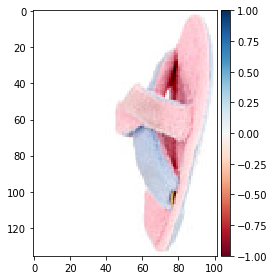

In [ ]:
transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

ds = ShoesDataset("meta-data.csv", img_paths, transform)
io.imshow(ds[0][0].cpu().numpy().T)

In [ ]:
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
trainset, testset = torch.utils.data.random_split(ds, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False, num_workers=2
)

In [ ]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # self.unpool = nn.MaxUnpool2d(kernel_size=2, padding=0)
        self.deconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=1)
        self.deconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, padding=0)

      
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        

        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv1(x))
        return x

model = AE().cuda()

KeyboardInterrupt: ignored

In [ ]:
from torchsummary import summary

x = next(iter(trainloader))[0].cuda()
y = model(x)
print(x.shape, y.shape)

summary(model.cuda(),(3,102,136))

torch.Size([128, 3, 102, 136]) torch.Size([128, 3, 102, 136])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 102, 136]             896
            Conv2d-2         [-1, 64, 102, 136]          18,496
         MaxPool2d-3           [-1, 64, 51, 68]               0
   ConvTranspose2d-4         [-1, 32, 100, 134]           8,224
   ConvTranspose2d-5          [-1, 3, 102, 136]             867
Total params: 28,483
Trainable params: 28,483
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.16
Forward/backward pass size (MB): 15.44
Params size (MB): 0.11
Estimated Total Size (MB): 15.71
----------------------------------------------------------------


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

count_loss = nn.MSELoss()

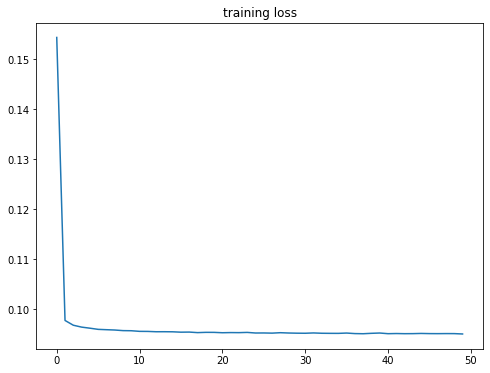

epoch : 50/50, loss = 0.095011


In [ ]:
epochs = 50
loss = []

for epoch in range(epochs):
    batchloss = 0
    for xbatch, _ in tqdm.notebook.tqdm(trainloader):  

        optimizer.zero_grad()
        outputs = model(xbatch.cuda())
        train_loss = count_loss(outputs.cuda(), xbatch.cuda())
        train_loss.backward()
        optimizer.step()
        
        batchloss += train_loss.item()
    

    loss.append(batchloss / len(trainloader))
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))

    fig, axs = plt.subplots(1, 1, figsize=(8, 6))
    clear_output(wait=True)
    axs.plot(loss)
    axs.set_title('training loss')
    plt.show()
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))

In [ ]:
with torch.no_grad():
  batchloss = 0
  for testx, testy in testloader:
    testx = testx.to("cuda")

    outputs = model(testx)
    batchloss += count_loss(outputs, testx)
    
  testloss = batchloss / len(testloader)
print(f"Test loss: {testloss}")

Test loss: 0.096457339823246


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 3, 102, 136])


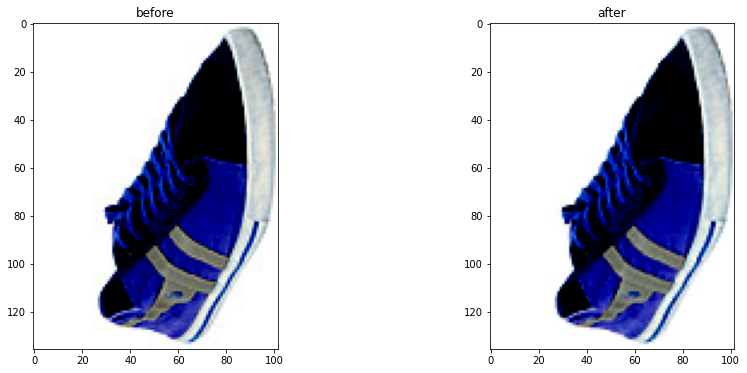

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


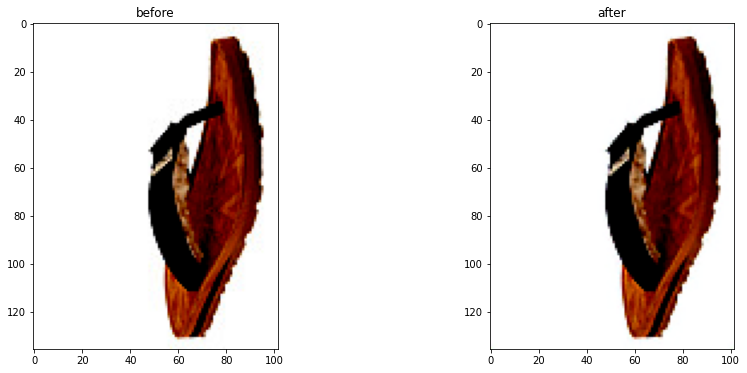

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


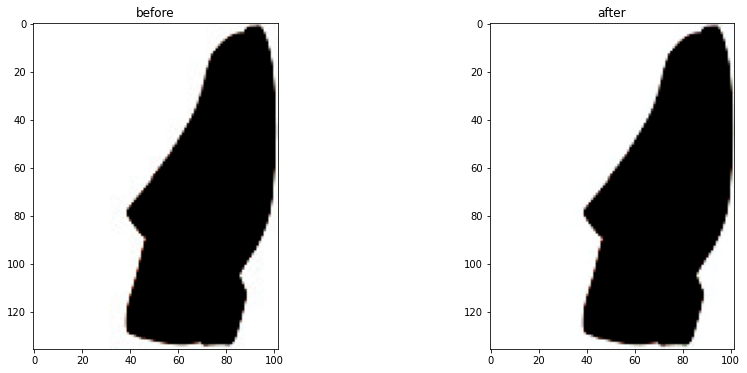

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


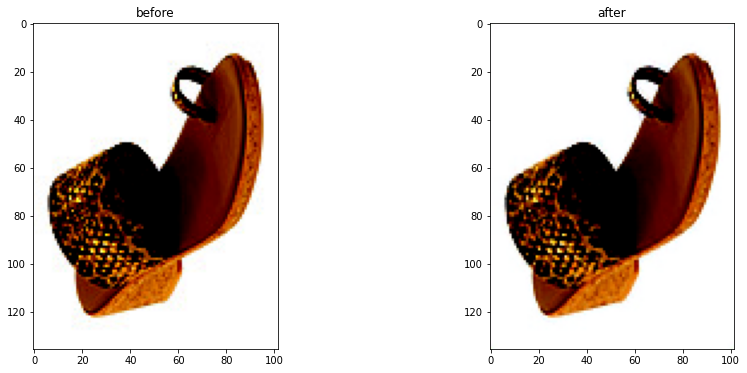

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


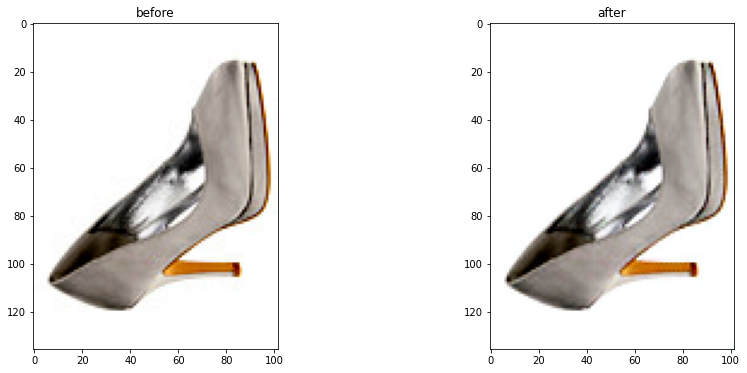

In [ ]:
with torch.no_grad():
  testx = next(iter(trainloader))[0][:5].to("cuda")

  predicted = model(testx)
  print(predicted.shape)

  for i in range(5):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].imshow(testx[i].to("cpu").numpy().T)
    axs[0].set_title('before')
    axs[1].imshow(predicted[i].to("cpu").numpy().T)
    axs[1].set_title('after')
    plt.show()

In [ ]:
'''
self.encoder_seq = nn.Sequential()
  self.encoder_seq.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)) # convolution
        self.encoder_seq.add_module('bn_conv1', nn.BatchNorm2d(16))
        self.encoder_seq.add_module('conv1_relu', nn.ReLU())
        self.encoder_seq.add_module('pool1', nn.MaxPool2d(kernel_size=2))

        self.encoder_seq.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)) # convolution
        self.encoder_seq.add_module('bn_conv2', nn.BatchNorm2d(32))
        self.encoder_seq.add_module('conv2_relu', nn.ReLU())
        self.encoder_seq.add_module('pool2', nn.MaxPool2d(kernel_size=2))

        self.encoder_seq.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)) # convolution
        self.encoder_seq.add_module('bn_conv3', nn.BatchNorm2d(64))
        self.encoder_seq.add_module('conv3_relu', nn.ReLU())
        self.encoder_seq.add_module('pool3', nn.MaxPool2d(kernel_size=2))


        self.decoder_seq = nn.Sequential()

        self.decoder_seq.add_module('deconv1', nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2)) # convolution
        self.decoder_seq.add_module('bn_deconv1', nn.BatchNorm2d(32))
        self.decoder_seq.add_module('deconv1_relu', nn.ReLU())

        self.decoder_seq.add_module('deconv2', nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2)) # convolution
        self.decoder_seq.add_module('deconv2_relu', nn.ReLU())

        self.decoder_seq.add_module('deconv3', nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=1)) # convolution
        self.decoder_seq.add_module('deconv3_relu', nn.ReLU())
'''

In [ ]:
class AE2(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.encoder_seq = nn.Sequential()

        self.encoder_seq.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)) # convolution
        self.encoder_seq.add_module('bn_conv1', nn.BatchNorm2d(16))
        self.encoder_seq.add_module('conv1_relu', nn.ReLU())
        self.encoder_seq.add_module('pool1', nn.MaxPool2d(kernel_size=3, stride=3))

        self.encoder_seq.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)) # convolution
        self.encoder_seq.add_module('conv2_relu', nn.ReLU())
        self.encoder_seq.add_module('pool2', nn.MaxPool2d(kernel_size=3, stride=3, padding=0))

        self.encoder_seq.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)) # convolution
        self.encoder_seq.add_module('bn_conv2', nn.BatchNorm2d(64))
        self.encoder_seq.add_module('conv3_relu', nn.ReLU())
        self.encoder_seq.add_module('pool3', nn.MaxPool2d(kernel_size=2, stride=2, padding=1))


        self.decoder_seq = nn.Sequential()

        self.decoder_seq.add_module('deconv1', nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=0)) # convolution
        self.decoder_seq.add_module('deconv1_relu', nn.ReLU())

        self.decoder_seq.add_module('deconv2', nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=3, padding=1)) # convolution
        self.decoder_seq.add_module('deconv2_relu', nn.ReLU())

        self.decoder_seq.add_module('deconv3', nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=3,padding=(0,1))) # convolution
        self.decoder_seq.add_module('deconv3_relu', nn.ReLU())

      
    def forward(self, x):
        x = self.encoder_seq(x)
        x = self.decoder_seq(x)
        return x

model = AE2().cuda()

In [ ]:
from torchsummary import summary

x = next(iter(trainloader))[0].cuda()
y = model(x)
print(x.shape, y.shape)

summary(model.cuda(),(3,102,136))

torch.Size([128, 3, 102, 136]) torch.Size([128, 3, 102, 136])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 102, 136]             448
       BatchNorm2d-2         [-1, 16, 102, 136]              32
              ReLU-3         [-1, 16, 102, 136]               0
         MaxPool2d-4           [-1, 16, 34, 45]               0
            Conv2d-5           [-1, 32, 34, 45]           4,640
              ReLU-6           [-1, 32, 34, 45]               0
         MaxPool2d-7           [-1, 32, 11, 15]               0
            Conv2d-8           [-1, 64, 11, 15]          18,496
       BatchNorm2d-9           [-1, 64, 11, 15]             128
             ReLU-10           [-1, 64, 11, 15]               0
        MaxPool2d-11             [-1, 64, 6, 8]               0
  ConvTranspose2d-12           [-1, 32, 12, 16]           8,224
             ReLU-13           [-1, 32, 1

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

count_loss = nn.MSELoss()

In [ ]:
epochs = 500
save = 40
test = 25
loss = []

for epoch in range(epochs):
    batchloss = 0
    for xbatch, _ in tqdm.notebook.tqdm(trainloader):  

        optimizer.zero_grad()
        outputs = model(xbatch.cuda())
        train_loss = count_loss(outputs.cuda(), xbatch.cuda())
        train_loss.backward()
        optimizer.step()
        
        batchloss += train_loss.item()
    

    loss.append(batchloss / len(trainloader))

    # save
    
    if epoch % save == 0:
      torch.save(model, f"conv-ae-v3-{epoch / save}.pt")

    # test loss

    testloss = 0
    if epoch % test == 0:
      with torch.no_grad():
        batchloss = 0
        for testx, testy in testloader:
          testx = testx.to("cuda")

          outputs = model(testx)
          batchloss += count_loss(outputs, testx)
          
        testloss = batchloss / len(testloader)

    # display 

    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))

    fig, axs = plt.subplots(1, 1, figsize=(8, 6))
    clear_output(wait=True)
    axs.plot(loss)
    axs.set_title('training loss')
    plt.show()
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))
    print(f"test loss: {testloss} (updated {epoch % test} epochs ago)")

RuntimeError: ignored

In [ ]:
examples = 10
with torch.no_grad():
  testx = next(iter(trainloader))[0][:examples].to("cuda")

  predicted = model(testx)
  print(predicted.shape)

  for i in range(examples):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].imshow(np.rot90(testx[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[0].set_title('before')
    axs[1].imshow(np.rot90(predicted[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[1].set_title('after')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
examples = 10
with torch.no_grad():
  testx = next(iter(trainloader))[0][:examples].to("cuda")

  predicted = model(testx)
  print(predicted.shape)

  for i in range(examples):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].imshow(np.rot90(testx[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[0].set_title('before')
    axs[1].imshow(np.rot90(predicted[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[1].set_title('after')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model = torch.load("conv-ae-v2-2.4.pt").cuda()
model.eval()

AE2(
  (encoder_seq): Sequential(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn_conv1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_relu): ReLU()
    (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_relu): ReLU()
    (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn_conv2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3_relu): ReLU()
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (decoder_seq): Sequential(
    (deconv1): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (deconv1_relu): ReLU()
    (deconv2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride

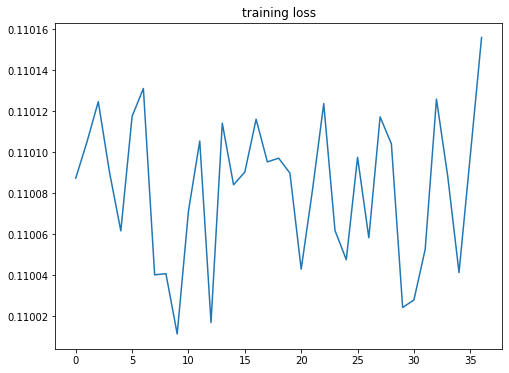

epoch : 37/500, loss = 0.110156
test loss: 0 (updated 11 epochs ago)


KeyboardInterrupt: ignored

In [ ]:
epochs = 500
save = 40
test = 25
loss = []

for epoch in range(epochs):
    batchloss = 0
    for xbatch, _ in tqdm.notebook.tqdm(trainloader):  

        optimizer.zero_grad()
        outputs = model(xbatch.cuda())
        train_loss = count_loss(outputs.cuda(), xbatch.cuda())
        train_loss.backward()
        optimizer.step()
        
        batchloss += train_loss.item()
    

    loss.append(batchloss / len(trainloader))

    # save
    
    if epoch % save == 0:
      torch.save(model, f"conv-ae-v3-{epoch / save}.pt")

    # test loss

    testloss = 0
    if epoch % test == 0:
      with torch.no_grad():
        batchloss = 0
        for testx, testy in testloader:
          testx = testx.to("cuda")

          outputs = model(testx)
          batchloss += count_loss(outputs, testx)
          
        testloss = batchloss / len(testloader)

    # display 

    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))

    fig, axs = plt.subplots(1, 1, figsize=(8, 6))
    clear_output(wait=True)
    axs.plot(loss)
    axs.set_title('training loss')
    plt.show()
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))
    print(f"test loss: {testloss} (updated {epoch % test} epochs ago)")

In [ ]:
examples = 10
with torch.no_grad():
  testx = next(iter(trainloader))[0][:examples].to("cuda")

  predicted = model(testx)
  print(predicted.shape)

  for i in range(examples):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].imshow(np.rot90(testx[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[0].set_title('before')
    axs[1].imshow(np.rot90(predicted[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[1].set_title('after')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
class AE3(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.encoder_seq = nn.Sequential()

        self.encoder_seq.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)) # convolution
        self.encoder_seq.add_module('bn_conv1', nn.BatchNorm2d(16))
        self.encoder_seq.add_module('conv1_relu', nn.ReLU())
        self.encoder_seq.add_module('pool1', nn.MaxPool2d(kernel_size=3, stride=3))

        self.encoder_seq.add_module('conv1-5', nn.Conv2d(in_channels=16, out_channels=16, kernel_size=2, padding=1))
        self.encoder_seq.add_module('conv1-5_relu', nn.ReLU())

        self.encoder_seq.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)) # convolution
        self.encoder_seq.add_module('conv2_relu', nn.ReLU())
        self.encoder_seq.add_module('pool2', nn.MaxPool2d(kernel_size=3, stride=3, padding=0))

        self.encoder_seq.add_module('conv2-5', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=1))
        self.encoder_seq.add_module('conv2-5_relu', nn.ReLU())

        self.encoder_seq.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)) # convolution
        self.encoder_seq.add_module('bn_conv2', nn.BatchNorm2d(128))
        self.encoder_seq.add_module('conv3_relu', nn.ReLU())
        self.encoder_seq.add_module('pool3', nn.MaxPool2d(kernel_size=2, stride=2, padding=0))


        self.decoder_seq = nn.Sequential()

        self.decoder_seq.add_module('deconv1', nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0)) # convolution
        self.decoder_seq.add_module('deconv1_relu', nn.ReLU())

        self.decoder_seq.add_module('deconv1-5', nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, padding=0))
        self.decoder_seq.add_module('deconv1-5_relu', nn.ReLU())
        self.decoder_seq.add_module('bn_deconv1', nn.BatchNorm2d(32))

        self.decoder_seq.add_module('deconv2', nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=3, padding=1)) # convolution
        self.decoder_seq.add_module('deconv2_relu', nn.ReLU())

        self.decoder_seq.add_module('deconv2-5', nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=2, padding=2))
        self.decoder_seq.add_module('deconv2-5_relu', nn.ReLU())
        self.decoder_seq.add_module('bn_deconv2', nn.BatchNorm2d(16))

        self.decoder_seq.add_module('deconv3', nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=3,padding=(0,1))) # convolution
        self.decoder_seq.add_module('deconv3_relu', nn.ReLU())
    
    def encode(self, x):
      self.encoded = self.encoder_seq(x)
      return self.encoded

    def decode(self, x):
      self.decoded = self.decoder_seq(x)
      return self.decoded

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

model = AE3().cuda()

In [ ]:
from torchsummary import summary

x = next(iter(trainloader))[0].cuda()
y = model(x)
print(x.shape, y.shape)

summary(model.cuda(),(3,102,136))

torch.Size([128, 3, 102, 136]) torch.Size([128, 3, 102, 136])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 102, 136]             448
       BatchNorm2d-2         [-1, 16, 102, 136]              32
              ReLU-3         [-1, 16, 102, 136]               0
         MaxPool2d-4           [-1, 16, 34, 45]               0
            Conv2d-5           [-1, 16, 35, 46]           1,040
              ReLU-6           [-1, 16, 35, 46]               0
            Conv2d-7           [-1, 32, 35, 46]           4,640
              ReLU-8           [-1, 32, 35, 46]               0
         MaxPool2d-9           [-1, 32, 11, 15]               0
           Conv2d-10           [-1, 64, 12, 16]           8,256
             ReLU-11           [-1, 64, 12, 16]               0
           Conv2d-12          [-1, 128, 12, 16]          73,856
      BatchNorm2d-13          [-1, 128, 1

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

count_loss = nn.MSELoss()

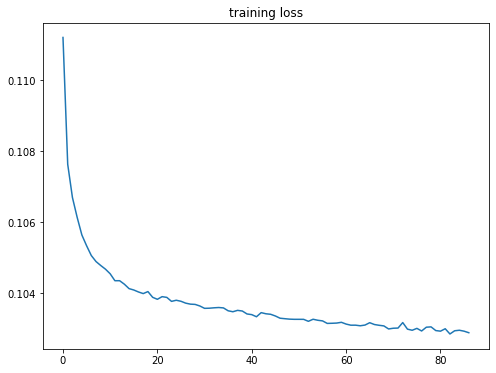

epoch : 87/500, loss = 0.102879
test loss: 0.10205023735761642 (updated 6 epochs ago)


KeyboardInterrupt: ignored

In [ ]:
epochs = 500
save = 25
test = 20
loss = []

for epoch in range(epochs):
    batchloss = 0
    model.train(True)
    for xbatch, _ in tqdm.notebook.tqdm(trainloader):  

        optimizer.zero_grad()
        outputs = model(xbatch.cuda())
        train_loss = count_loss(outputs.cuda(), xbatch.cuda())
        train_loss.backward()
        optimizer.step()
        
        batchloss += train_loss.item()
    

    loss.append(batchloss / len(trainloader))

    # save
    
    if epoch % save == 0:
      torch.save(model, f"conv-ae-v4-{epoch / save}.pt")

    # test loss

    
    if epoch % test == 0:
      with torch.no_grad():
        model.train(False)
        batchloss = 0
        for testx, testy in testloader:
          testx = testx.to("cuda")

          outputs = model(testx)
          batchloss += count_loss(outputs, testx)
          
        testloss = batchloss / len(testloader)

    # display 

    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))

    fig, axs = plt.subplots(1, 1, figsize=(8, 6))
    clear_output(wait=True)
    axs.plot(loss)
    axs.set_title('training loss')
    plt.show()
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))
    print(f"test loss: {testloss} (updated {epoch % test} epochs ago)")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 102, 136])


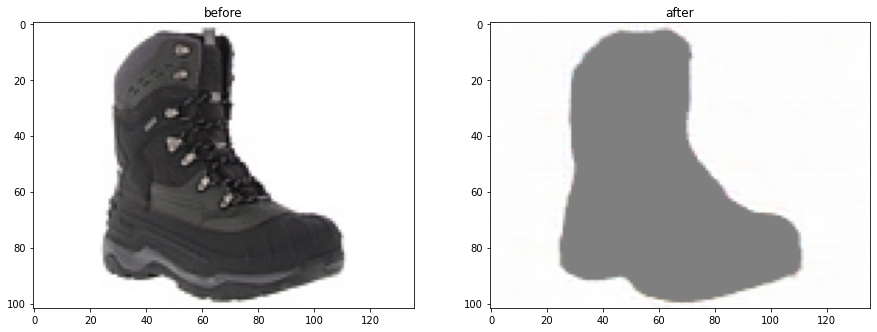

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


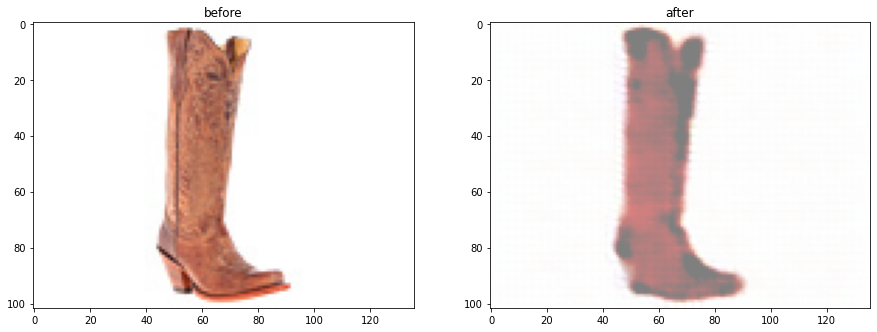

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


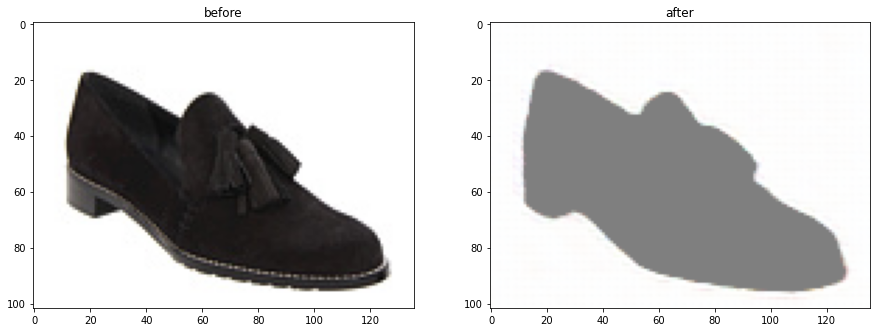

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


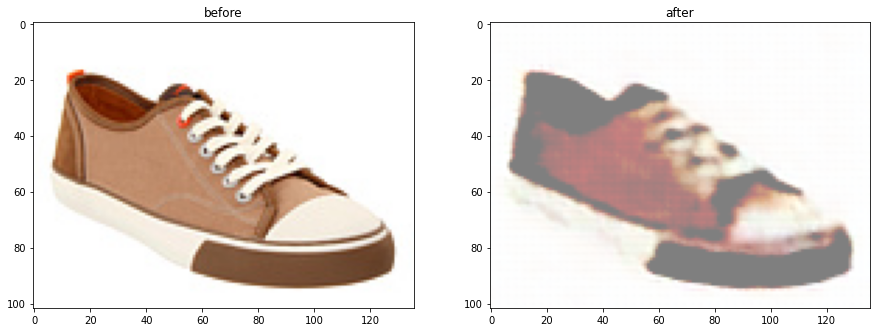

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


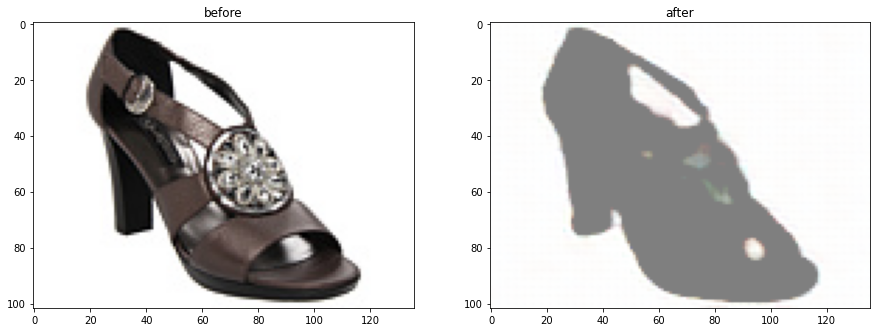

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


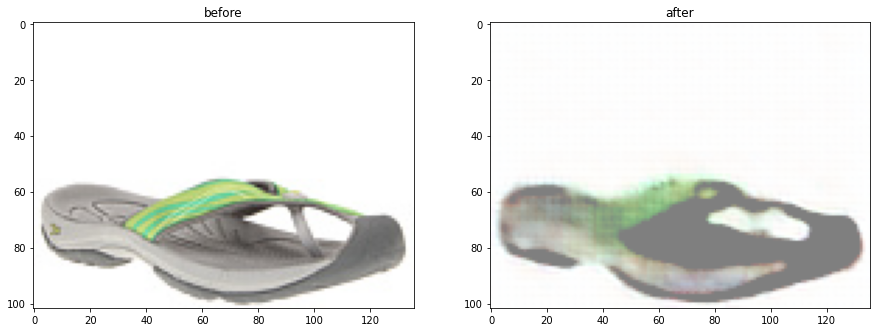

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


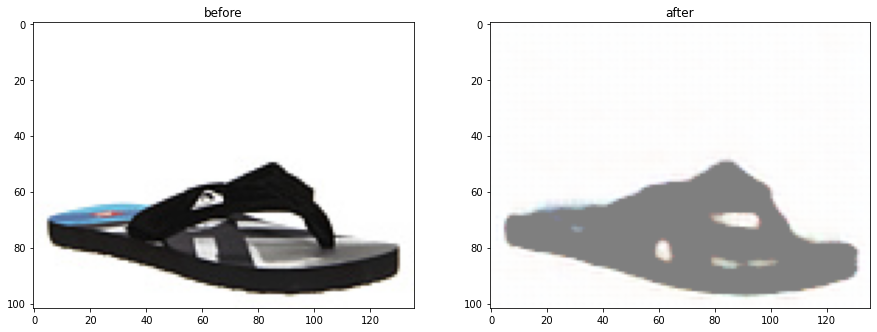

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


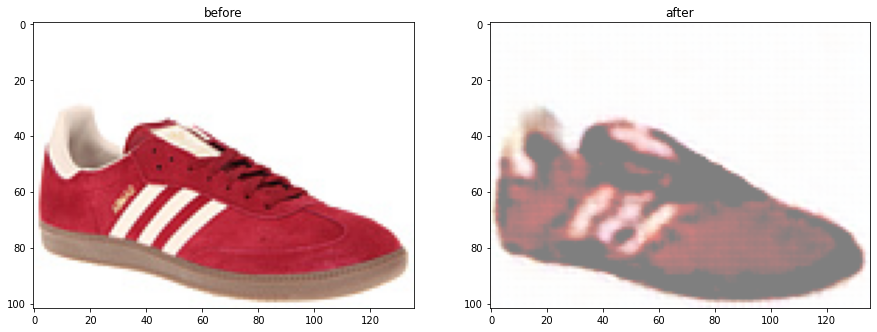

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


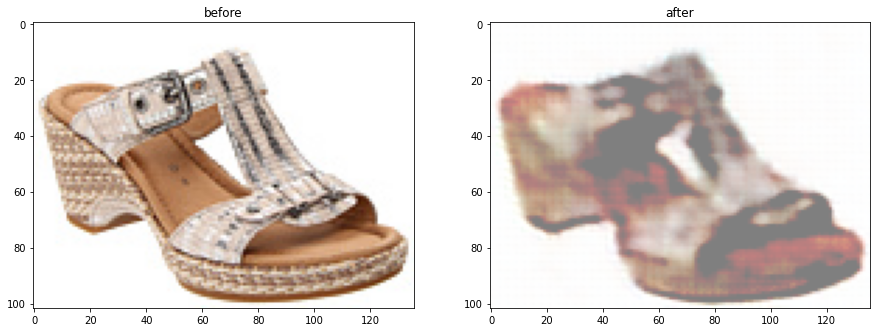

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


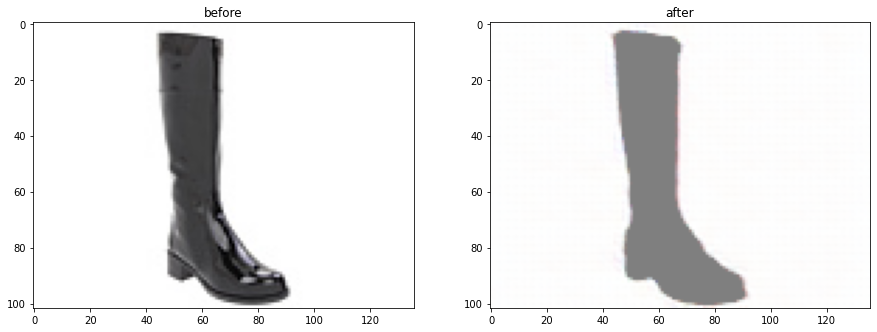

In [ ]:
examples = 10
with torch.no_grad():
  testx = next(iter(trainloader))[0][:examples].to("cuda")

  predicted = model(testx)
  print(predicted.shape)

  for i in range(examples):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].imshow(np.rot90(testx[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[0].set_title('before')
    axs[1].imshow(np.rot90(predicted[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[1].set_title('after')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

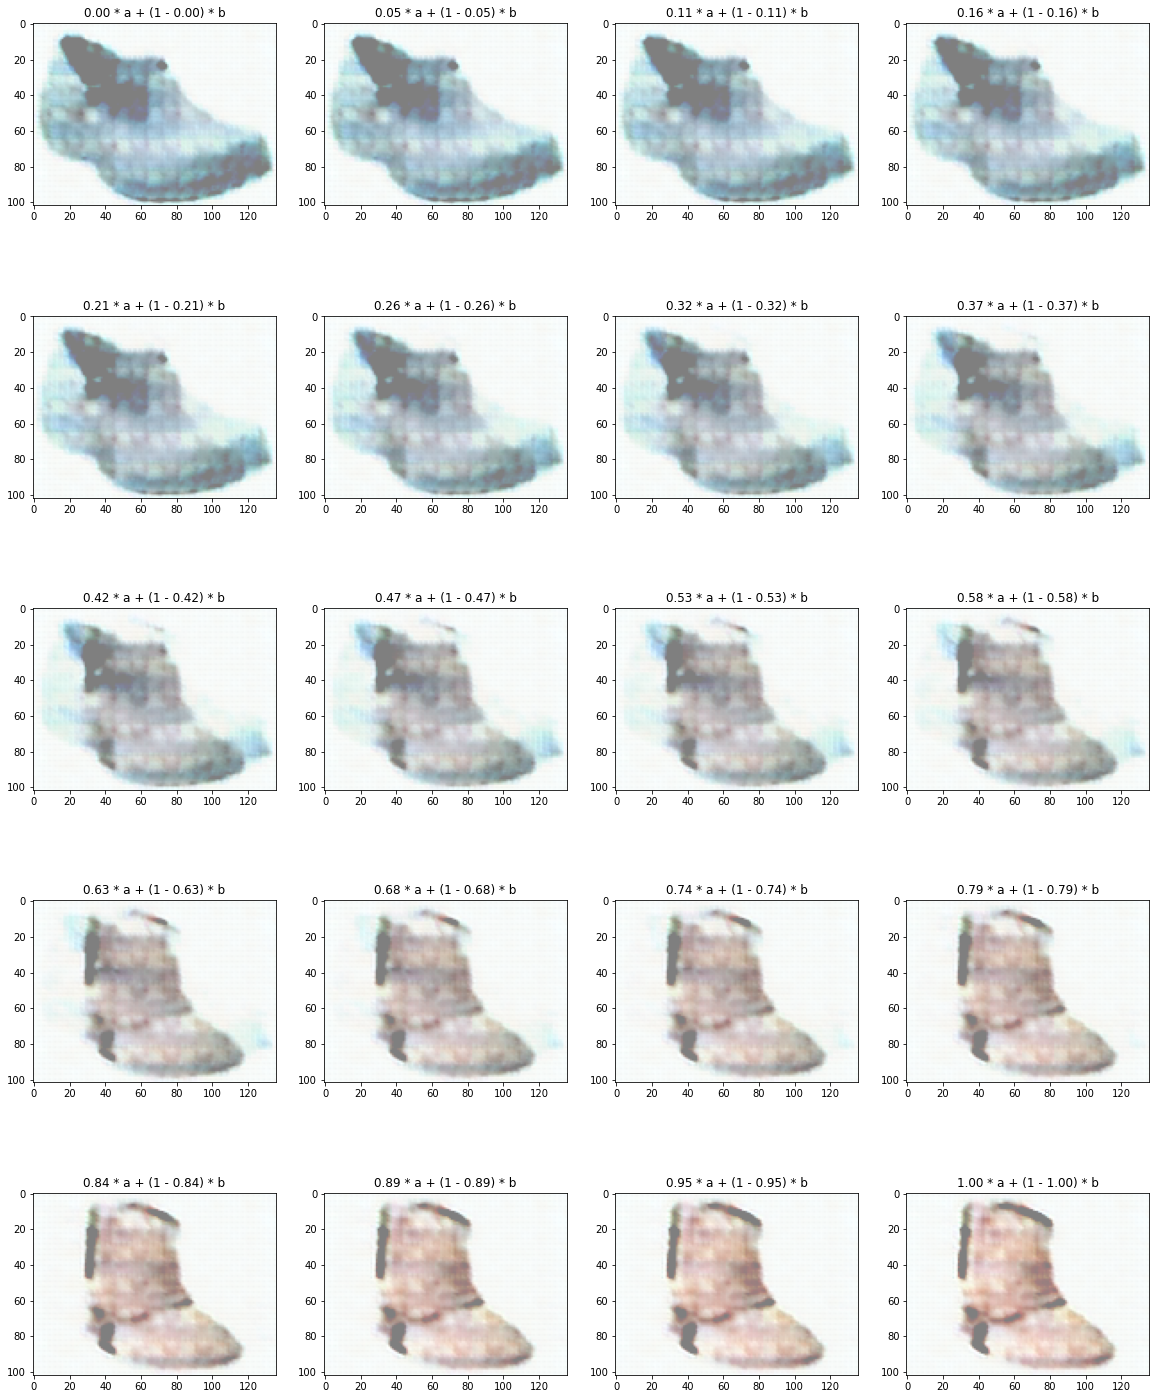

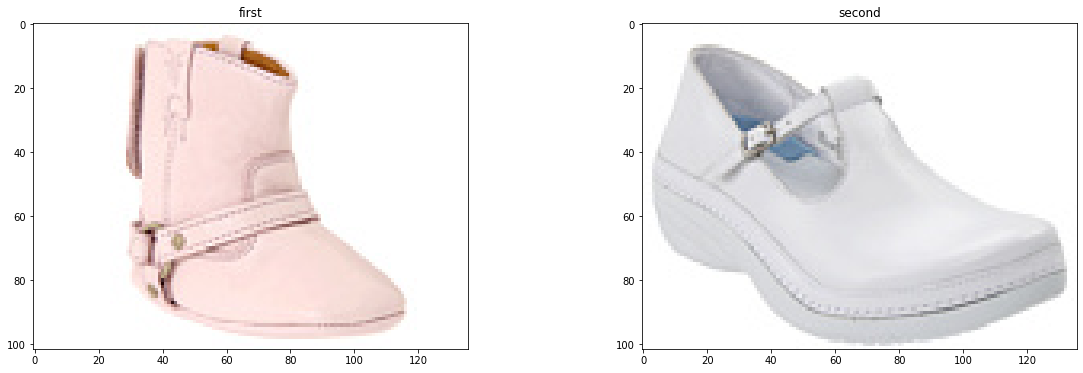

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


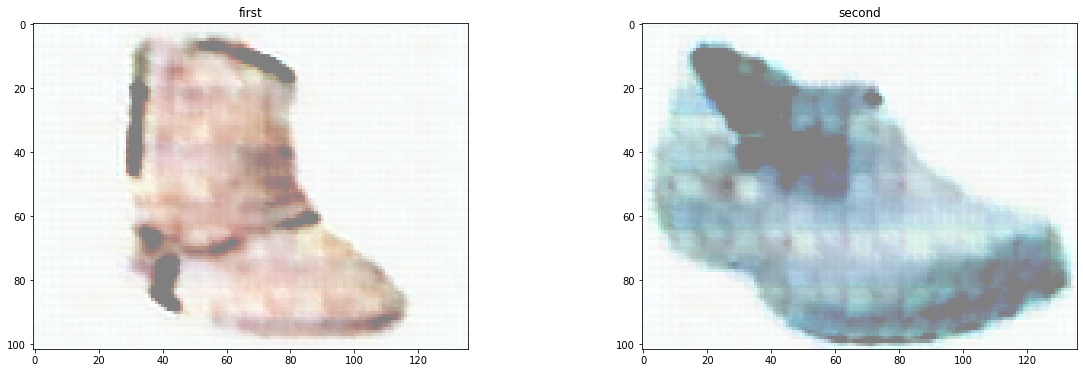

In [ ]:
a = ds[25025][0]
b = ds[12312][0]
batch = torch.stack((a,b)).cuda()

fig, axs = plt.subplots(5, 4, figsize=(20, 26))

i = 0
with torch.no_grad():
  complete = model(batch)
  encoded = model.encode(batch)

  model.train(False)

  for alpha in np.linspace(0,1,num=20):
    
    mix = alpha * encoded[0] + (1 - alpha) * encoded[1]
    decoded = model.decode(torch.stack((mix,mix)))

    axs[i // 4, i%4].imshow(np.rot90(decoded[0].to('cpu').numpy().T / 2 + 0.5,k=-1))
    axs[i // 4, i%4].set_title(f'{alpha:.2f} * a + (1 - {alpha:.2f}) * b')
    i+=1

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].imshow(np.rot90(a.to("cpu").numpy().T / 2 + 0.5,k=-1))
axs[0].set_title('first')
axs[1].imshow(np.rot90(b.to("cpu").numpy().T / 2 + 0.5,k=-1))
axs[1].set_title('second')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].imshow(np.rot90(complete[0].to("cpu").numpy().T / 2 + 0.5,k=-1))
axs[0].set_title('first')
axs[1].imshow(np.rot90(complete[1].to("cpu").numpy().T / 2 + 0.5,k=-1))
axs[1].set_title('second')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 102, 136])


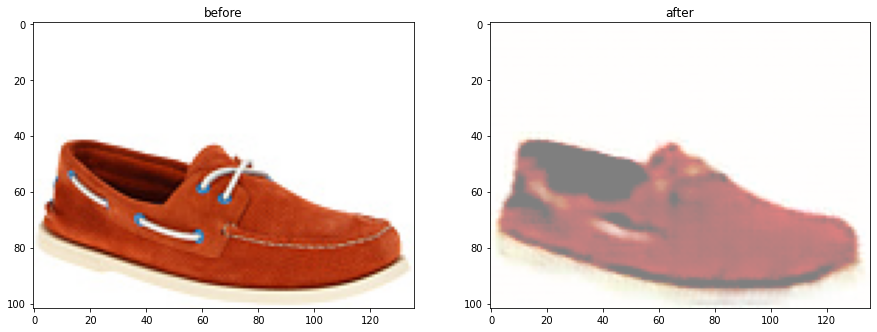

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


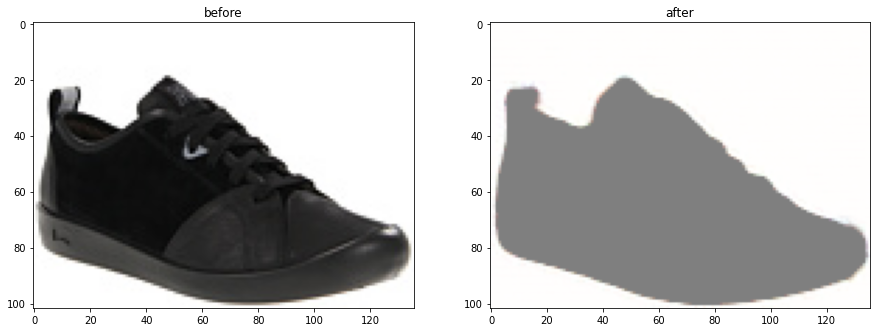

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


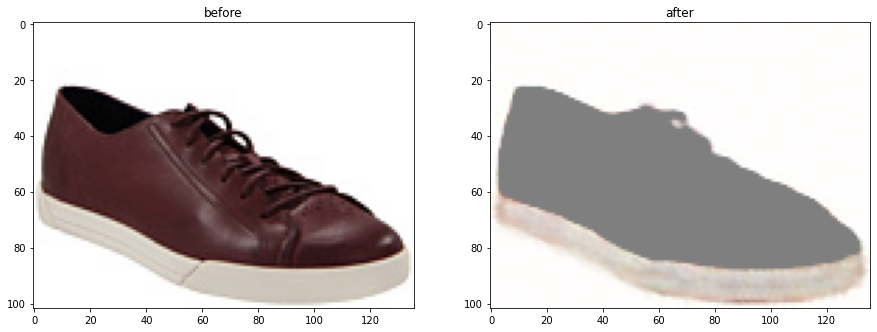

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


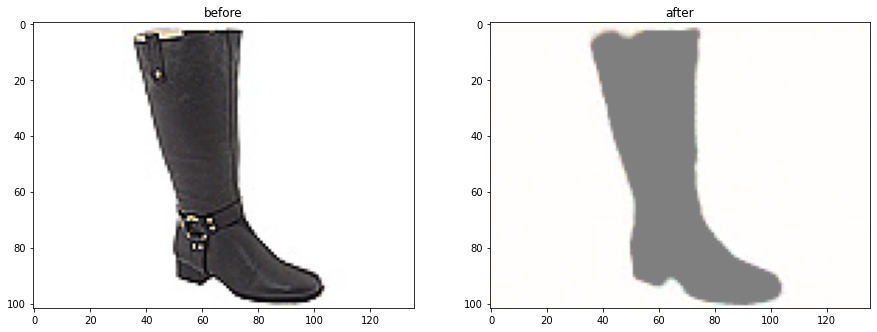

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


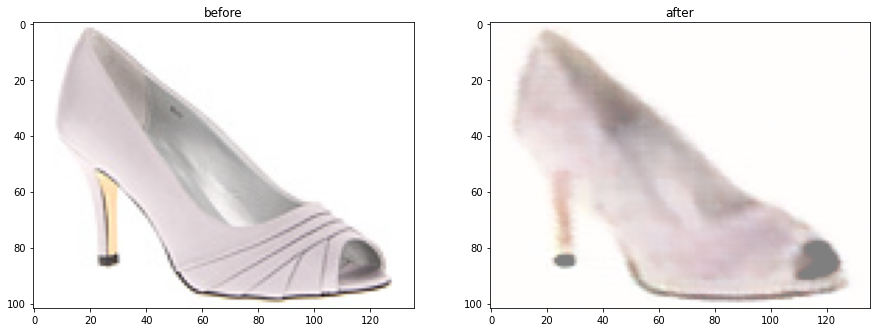

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


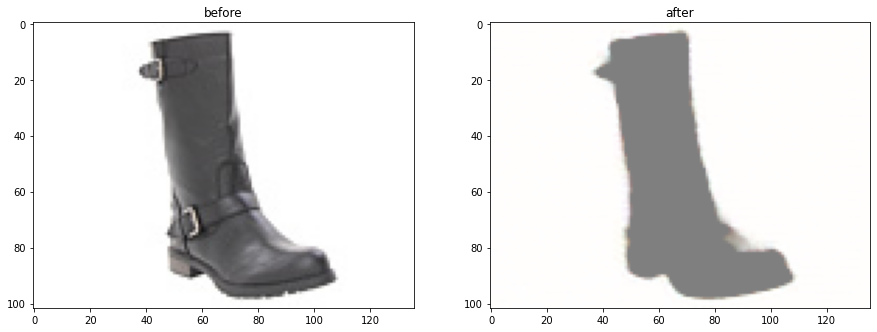

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


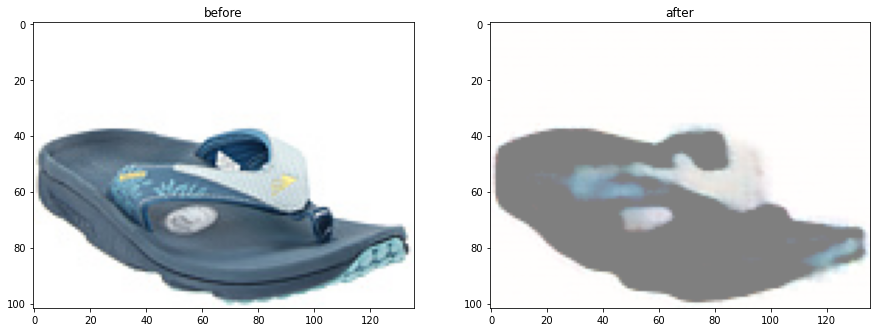

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


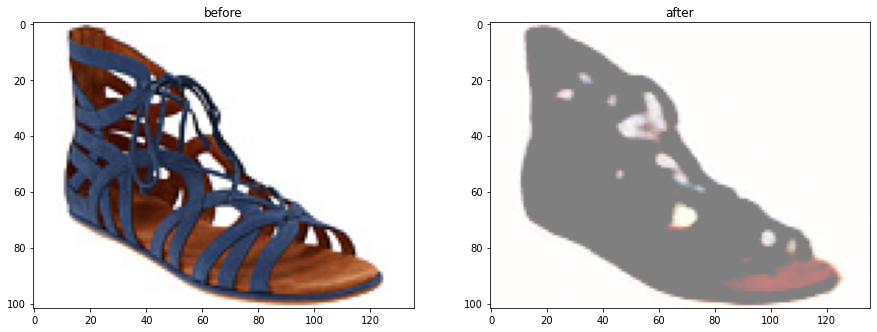

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


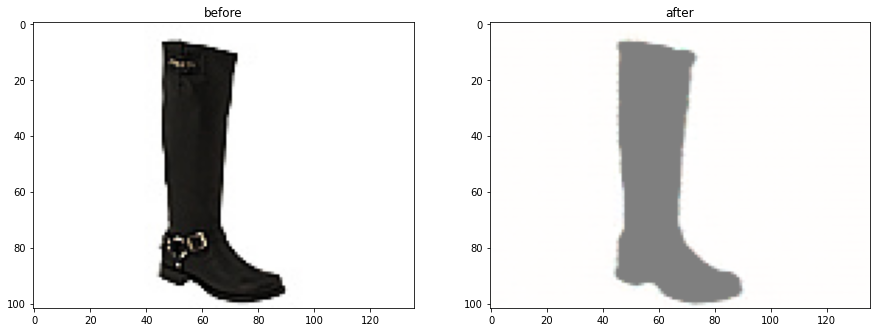

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


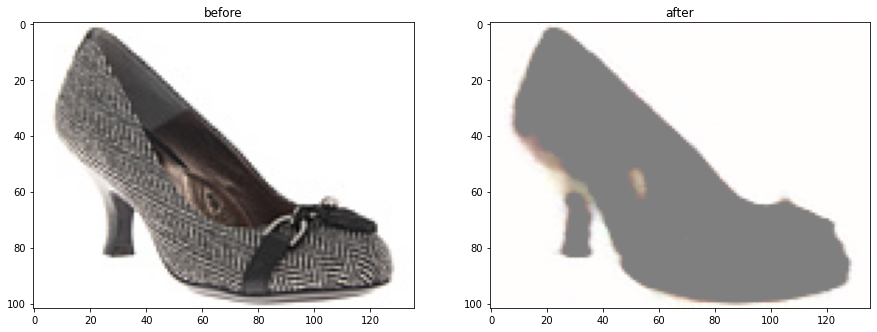

In [ ]:
examples = 10
with torch.no_grad():
  testx = next(iter(trainloader))[0][:examples].to("cuda")

  predicted = model(testx)
  print(predicted.shape)

  for i in range(examples):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].imshow(np.rot90(testx[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[0].set_title('before')
    axs[1].imshow(np.rot90(predicted[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[1].set_title('after')
    plt.show()

In [ ]:
encoded[0].shape

torch.Size([128, 6, 8])

In [ ]:
128 * 6 * 8

6144

In [ ]:
pred.shape

torch.Size([3, 102, 136])

In [ ]:
# knn 
# bot 